In [1]:
import torch
import sys
import os
import importlib
import torch
import numpy
import torch.nn.functional as F
from scipy.io import wavfile
from collections import defaultdict

In [107]:
out_path = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores.txt'
trials = '/workspace/DATASET/server9_ssd/PVTC20/task1/trials_competitor'
test_path = '/workspace/DATASET/server9_ssd/PVTC20/task1/wav_data'

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [126]:
sys.path.append('/workspace/GREAT_ASV_system/train_dist')
sys.path.append('/workspace/GREAT_ASV_system/PVTC20')
sys.path.append('/workspace/GREAT_ASV_system/new_backend')

In [81]:
from tuneThreshold_pvtc import *

In [5]:
# from DatasetLoader import loadWAV

In [4]:
SpeakerNetModel = importlib.import_module('models.'+'EPACA-TDNN').__getattribute__('MainModel')

In [5]:
# EPACA-TDNN
S = SpeakerNetModel(n_mels=40, nOut=192, spec_aug=False)

EPACA-TDNN.py, Embedding size is 192, Channels 1024, Spec_aug False.


In [6]:
model_path = '/workspace/LOGS_OUTPUT/tmp_logs/train_logs_201120/multi_gpu_epaca_tdnn_soxaug/model/model000000034.model'

In [7]:
S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [8]:
loaded_state = torch.load(model_path, map_location="cuda:0")

In [9]:
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name
    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
        continue

    self_state[name].copy_(param)

#__L__.W is not in the model.


In [10]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [11]:
def loadWAV(filename, last_seconds):

    # Maximum audio length
    
    max_audio = int(last_seconds*16000 + 240)

    # Read wav file and convert to torch tensor
    sample_rate, audio  = wavfile.read(filename)
    
    audio = audio[-max_audio:]

    audiosize = audio.shape[0]

    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
        audiosize   = audio.shape[0]
    
    feats = []

    feats.append(audio)

    feat = numpy.stack(feats,axis=0).astype(numpy.float)

    return feat

In [108]:
listfilename = trials
files = []
with open(listfilename, 'r') as listfile:
    while True:
        line = listfile.readline()
        if (not line):
            break

        data = line.split()

        files.append(data[0])
        files.append(data[1])
        files.append(data[2])
        files.append(data[3])

setfiles = list(set(files))
setfiles.sort()

In [109]:
len(setfiles)

162413

In [110]:
test_dict = {}
for count, line in enumerate(setfiles):
    wavline = line
    wavline = os.path.join(test_path, wavline)
    raw_inp = loadWAV(wavline, last_seconds=1.0)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu()

    test_dict[line] = ref_feat
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

In [111]:
len(test_dict)

162413

In [112]:
listfilename = trials
enroll_files = []
with open(listfilename, 'r') as listfile:
    while True:
        line = listfile.readline()
        if (not line):
            break

        data = line.split()

        enroll_files.append(data[0]+' '+data[1]+' '+data[2])

enroll_files = list(set(enroll_files))
enroll_files.sort()

In [113]:
len(enroll_files)

1070

In [114]:
enroll_dict_mean_nm = {}
for i in enroll_files:
    data1, data2, data3 = i.split(' ')
    emb1, emb2, emb3 = test_dict[data1], test_dict[data2], test_dict[data3]
    emb = torch.cat([emb1, emb2, emb3], dim=0)
    emb = torch.mean(emb, dim=0, keepdim=False)
    emb = F.normalize(emb, p=2, dim=0)
    enroll_dict_mean_nm[i] = emb

In [115]:
len(enroll_dict_mean_nm)

1070

In [116]:
test_dict_nm = {}
for i in test_dict:
    emb = test_dict[i]
    emb = F.normalize(emb.squeeze(0), p=2, dim=0)
    test_dict_nm[i] = emb

In [117]:
len(test_dict_nm)

162413

In [118]:
with open(trials, 'r') as f:
    trial_lines = f.readlines()

In [119]:
len(trial_lines)

876000

In [120]:
with open(out_path, 'w') as f:
    for count, line in enumerate(trial_lines):
        line = line[:-1]
        data = line.split(' ')
        enroll_label = data[0]+' '+data[1]+' '+data[2]
        test_label = data[-1]
        
        enroll_emb = enroll_dict_mean_nm[enroll_label]
        test_emb = test_dict_nm[test_label]
        
        score = F.cosine_similarity(enroll_emb, test_emb, dim=0).cpu().numpy()
        f.write('%s %s %.4f\n'%(enroll_label, test_label, score))
        
        if ((count+1) % 10000) == 0:
            print((count+1) // 10000, end='\r')

In [74]:
score_list = []
for count, line in enumerate(trial_lines):
    line = line[:-1]
    data = line.split(' ')
    enroll_label = data[0]+' '+data[1]+' '+data[2]
    test_label = data[-1]

    enroll_emb = enroll_dict_mean_nm[enroll_label]
    test_emb = test_dict_nm[test_label]

    score = F.cosine_similarity(enroll_emb, test_emb, dim=0).cpu().numpy()
    score_list.append(score)

    if ((count+1) % 10000) == 0:
        print((count+1) // 10000, end='\r')

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
len(score_list)

876000

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 2.000e+00,
        4.000e+00, 7.000e+00, 3.000e+00, 1.600e+01, 1.300e+01, 1.800e+01,
        1.500e+01, 1.100e+01, 1.100e+01, 1.700e+01, 2.200e+01, 2.100e+01,
        1.400e+01, 1.900e+01, 3.700e+01, 2.700e+01, 2.900e+01, 2.600e+01,
        3.900e+01, 4.200e+01, 5.200e+01, 4.700e+01, 6.000e+01, 7.700e+01,
        6.900e+01, 7.800e+01, 9.000e+01, 7.800e+01, 9.800e+01, 1.040e+02,
        1.000e+02, 1.430e+02, 1.550e+02, 1.460e+02, 1.500e+02, 1.700e+02,
        2.100e+02, 2.040e+02, 2.470e+02, 2.350e+02, 2.730e+02, 2.840e+02,
        3.310e+02, 3.220e+02, 3.550e+0

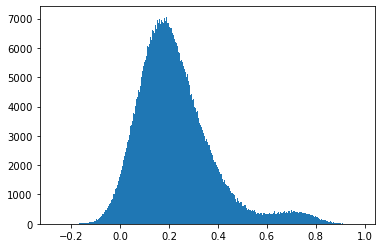

In [81]:
plt.hist(score_list, bins=500)

In [83]:
final_spk_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_out.txt'

In [84]:
TH = 0.47
with open(final_spk_out, 'w') as f:
    for count, line in enumerate(trial_lines):
        line = line[:-1]
        data = line.split(' ')
        enroll_label = data[0]+' '+data[1]+' '+data[2]
        test_label = data[-1]
        
        enroll_emb = enroll_dict_mean_nm[enroll_label]
        test_emb = test_dict_nm[test_label]
        
        score = F.cosine_similarity(enroll_emb, test_emb, dim=0).cpu().numpy()
        
        if score >= TH:
            score = 1
        else:
            score = 0
        
        f.write('%s %s %d\n'%(enroll_label, test_label, score))
        
        if ((count+1) % 10000) == 0:
            print((count+1) // 10000, end='\r')

## combine

In [85]:
final_kws_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/kws_output.txt'

In [86]:
with open(final_kws_out, 'r') as f:
    kws_lines = f.readlines()

In [87]:
len(kws_lines)

876000

In [90]:
final_spk_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_out.txt'

In [91]:
with open(final_spk_out, 'r') as f:
    spk_lines = f.readlines()

In [92]:
len(spk_lines)

876000

In [95]:
final_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/baseline_output.txt'

In [104]:
with open(final_out, 'w') as f:
    for count, [k_line, s_line] in enumerate(zip(kws_lines, spk_lines)):
        k_line = k_line[:-1]
        s_line = s_line[:-1]
        
        k_data = k_line.split(' ')
        s_data = s_line.split(' ')
        
        k = k_data[0]+' '+k_data[1]+' '+k_data[2]+' '+k_data[3]
        s = s_data[0]+' '+s_data[1]+' '+s_data[2]+' '+s_data[3]
        
        assert k == s
        
        score = int(int(k_data[-1]) and int(s_data[-1]))
        
        f.write('%s %d\n'%(k, score))
        
        if ((count+1) % 10000) == 0:
            print((count+1) // 10000, end='\r')

## Dev tune only on speech with 'xiaolexiaole'

In [12]:
dev_trials = '/workspace/DATASET/server9_ssd/PVTC20/dev/task1/trials'
dev_kws = '/workspace/DATASET/server9_ssd/PVTC20/dev/task1/trials_for_wake'
dev_path = '/workspace/DATASET/server9_ssd/PVTC20/dev/task1/wav_data'

In [13]:
with open(dev_kws, 'r') as f:
    kws_keys = f.readlines()

In [14]:
len(kws_keys)

105000

In [16]:
kws_pos = []
for i in kws_keys:
    i = i[:-1]
    data, label = i.split(' ')
    if label == 'positive':
        kws_pos.append(data)

In [17]:
len(kws_pos)

65000

In [18]:
with open(dev_trials, 'r') as f:
    trial_keys = f.readlines()

In [19]:
len(trial_keys)

105000

In [25]:
target_trials = []
for count, i in enumerate(trial_keys):
    i = i[:-1]
    test_wav = i.split(' ')[-2]
    if test_wav in kws_pos:
        target_trials.append(i)
    if ((count+1) % 1000) ==0:
        print((count+1)//1000, end='\r')

In [26]:
len(target_trials)

65000

In [31]:
devfiles = []

for line in target_trials:

    data = line.split(' ')

    devfiles.append(data[0])
    devfiles.append(data[1])
    devfiles.append(data[2])
    devfiles.append(data[3])

devfiles = list(set(devfiles))
devfiles.sort()

In [32]:
len(devfiles)

16834

In [34]:
dev_dict = {}
for count, line in enumerate(devfiles):
    wavline = line
    wavline = os.path.join(dev_path, wavline)
    raw_inp = loadWAV(wavline, last_seconds=1.0)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu()

    dev_dict[line] = ref_feat
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

In [35]:
len(dev_dict)

16834

In [42]:
dev_enroll_files = []
for line in target_trials:
    data = line.split()
    
    dev_enroll_files.append(data[0]+' '+data[1]+' '+data[2])

dev_enroll_files = list(set(dev_enroll_files))
dev_enroll_files.sort()

In [43]:
len(dev_enroll_files)

559

In [44]:
dev_enroll_dict_mean_nm = {}
for i in dev_enroll_files:
    data1, data2, data3 = i.split(' ')
    emb1, emb2, emb3 = dev_dict[data1], dev_dict[data2], dev_dict[data3]
    emb = torch.cat([emb1, emb2, emb3], dim=0)
    emb = torch.mean(emb, dim=0, keepdim=False)
    emb = F.normalize(emb, p=2, dim=0)
    dev_enroll_dict_mean_nm[i] = emb

In [45]:
len(dev_enroll_dict_mean_nm)

559

In [47]:
count = 0
for i in target_trials:
    if i.split(' ')[-1] == 'positive':
        count += 1
print(count)

5000


In [48]:
len(target_trials)

65000

In [50]:
dev_dict_nm = {}
for i in dev_dict:
    emb = dev_dict[i]
    emb = F.normalize(emb.squeeze(0), p=2, dim=0)
    dev_dict_nm[i] = emb

In [51]:
len(dev_dict_nm)

16834

In [56]:
score_list = []
key_list = []
for count, line in enumerate(target_trials):
    data = line.split(' ')
    enroll_label = data[0]+' '+data[1]+' '+data[2]
    test_label = data[3]
    key = 1 if data[-1]=='positive' else 0

    enroll_emb = dev_enroll_dict_mean_nm[enroll_label]
    test_emb = dev_dict_nm[test_label]

    score = F.cosine_similarity(enroll_emb, test_emb, dim=0).cpu().numpy()
    score_list.append(score)
    
    key_list.append(key)
    

    if ((count+1) % 10000) == 0:
        print((count+1) // 10000, end='\r')

In [72]:
result = tuneThresholdfromScore_pvtc20_minc(score_list, key_list)

In [73]:
## eer
result[1]

4.2299999999999995

In [74]:
## minc@0.05
result[-2]

0.20771666666666666

In [76]:
## TH
result[0]

[[0.58206385, 0.20166666666666666, 16.939999999999998]]

## Dev tune only on speech with all (regardless of kws)

In [12]:
dev_trials = '/workspace/DATASET/server9_ssd/PVTC20/dev/task1/trials'
dev_path = '/workspace/DATASET/server9_ssd/PVTC20/dev/task1/wav_data'

In [82]:
with open(dev_trials, 'r') as f:
    trial_keys = f.readlines()

In [83]:
len(trial_keys)

105000

In [84]:
target_trials = []
for count, i in enumerate(trial_keys):
    i = i[:-1]

    target_trials.append(i)
    if ((count+1) % 1000) ==0:
        print((count+1)//1000, end='\r')

In [85]:
len(target_trials)

105000

In [86]:
devfiles = []

for line in target_trials:

    data = line.split(' ')

    devfiles.append(data[0])
    devfiles.append(data[1])
    devfiles.append(data[2])
    devfiles.append(data[3])

devfiles = list(set(devfiles))
devfiles.sort()

In [87]:
len(devfiles)

26529

In [88]:
dev_dict = {}
for count, line in enumerate(devfiles):
    wavline = line
    wavline = os.path.join(dev_path, wavline)
    raw_inp = loadWAV(wavline, last_seconds=1.0)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu()

    dev_dict[line] = ref_feat
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

In [89]:
len(dev_dict)

26529

In [90]:
dev_enroll_files = []
for line in target_trials:
    data = line.split()
    
    dev_enroll_files.append(data[0]+' '+data[1]+' '+data[2])

dev_enroll_files = list(set(dev_enroll_files))
dev_enroll_files.sort()

In [91]:
len(dev_enroll_files)

559

In [92]:
dev_enroll_dict_mean_nm = {}
for i in dev_enroll_files:
    data1, data2, data3 = i.split(' ')
    emb1, emb2, emb3 = dev_dict[data1], dev_dict[data2], dev_dict[data3]
    emb = torch.cat([emb1, emb2, emb3], dim=0)
    emb = torch.mean(emb, dim=0, keepdim=False)
    emb = F.normalize(emb, p=2, dim=0)
    dev_enroll_dict_mean_nm[i] = emb

In [93]:
len(dev_enroll_dict_mean_nm)

559

In [94]:
count = 0
for i in target_trials:
    if i.split(' ')[-1] == 'positive':
        count += 1
print(count)

5000


In [95]:
len(target_trials)

105000

In [96]:
dev_dict_nm = {}
for i in dev_dict:
    emb = dev_dict[i]
    emb = F.normalize(emb.squeeze(0), p=2, dim=0)
    dev_dict_nm[i] = emb

In [97]:
len(dev_dict_nm)

26529

In [98]:
score_list = []
key_list = []
for count, line in enumerate(target_trials):
    data = line.split(' ')
    enroll_label = data[0]+' '+data[1]+' '+data[2]
    test_label = data[3]
    key = 1 if data[-1]=='positive' else 0

    enroll_emb = dev_enroll_dict_mean_nm[enroll_label]
    test_emb = dev_dict_nm[test_label]

    score = F.cosine_similarity(enroll_emb, test_emb, dim=0).cpu().numpy()
    score_list.append(score)
    
    key_list.append(key)
    

    if ((count+1) % 10000) == 0:
        print((count+1) // 10000, end='\r')

In [99]:
result = tuneThresholdfromScore_pvtc20_minc(score_list, key_list)

In [100]:
## eer
result[1]

3.927

In [101]:
## minc@0.05
result[-2]

0.19288999999999992

In [102]:
## TH
result[0]

[[0.56074214, 0.291, 13.759999999999994]]

## use dev TH to set testing TH

In [103]:
TH = 0.5607

In [121]:
final_spk_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores.txt'
final_spk_out_tune = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_tune_out.txt'

In [122]:
with open(final_spk_out, 'r') as f:
    ori_out = f.readlines()

In [123]:
ori_out[0]

'PVTC_task1_0001.wav PVTC_task1_0002.wav PVTC_task1_0003.wav PVTC_task1_0004.wav 0.5597\n'

In [125]:
with open(final_spk_out_tune, 'w') as f:
    for line in ori_out:
        line = line[:-1]
        score = float(line.split(' ')[-1])
        if score > TH:
            score = 1
        else:
            score = 0
        data = line.split(' ')
        f.write(data[0]+' '+data[1]+' '+data[2]+' '+data[3]+' '+str(score)+'\n')

## socre norm

In [128]:
with open(trials, 'r') as f:
    trial_list = f.readlines()

In [135]:
pure_test_list = []
for i in trial_list:
    pure_test_list.append(i[:-1].split(' ')[-1])
pure_test_list = list(set(pure_test_list))
pure_test_list.sort()

In [137]:
len(pure_test_list)

159235

In [143]:
len(dev_enroll_dict_mean_nm)

559

In [142]:
len(enroll_dict_mean_nm)

1070

In [140]:
pure_test_dict_nm = {}
for i in pure_test_list:
    pure_test_dict_nm[i] = test_dict_nm[i]

In [141]:
len(pure_test_dict_nm)

159235

In [181]:
cohort2enroll = {}
for count, i in enumerate(dev_enroll_dict_mean_nm):
    chort = dev_enroll_dict_mean_nm[i]
    for j in enroll_dict_mean_nm:
        enroll = enroll_dict_mean_nm[j]
        cohort2enroll[i+'|'+j] = F.cosine_similarity(chort, enroll, dim=0).cpu().numpy()
    print(count+1, end='\r')

In [182]:
len(cohort2enroll)

598130

In [183]:
cohort2test = {}
for count, i in enumerate(dev_enroll_dict_mean_nm):
    chort = dev_enroll_dict_mean_nm[i]
    for j in pure_test_dict_nm:
        test = pure_test_dict_nm[j]
        cohort2test[i+'|'+j] = F.cosine_similarity(chort, test, dim=0).cpu().numpy()
    print(count+1, end='\r')

In [184]:
len(cohort2test)

89012365

In [185]:
159235 * 559

89012365

In [175]:
out_path = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores_as2.txt'
file_score_path = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores.txt'
top_num=400
hold_name=True
dict_sep='|'

In [190]:
def as_norm_2(file_score_path, out_path, cohort2enroll, cohort2test, top_num=200, hold_name=True, dict_sep=' '):
# operation: norm_score = 0.5* ((score-mean_e_t)/str_e_t+(score-mean_t_e)/str_t_e)
    print('Score norm operation start, method: Adaptive_score_norm_type_2')

    file_scores_as_norm_path = out_path
    enroll_dict = defaultdict(dict)
    test_dict = defaultdict(dict)

    for count, i in enumerate(cohort2enroll):
        cohort_utt = i.split(dict_sep)[0]
        enroll_utt = i.split(dict_sep)[1]
        score = float(cohort2enroll[i])
        enroll_dict[enroll_utt][cohort_utt] = score 

        if ((count+1) % 100000) == 0:
            print('read c2e:', (count+1)//100000, end='\r')      

    for count, i in enumerate(cohort2test):
        cohort_utt = i.split(dict_sep)[0]
        test_utt = i.split(dict_sep)[1]
        score = float(cohort2test[i])
        test_dict[test_utt][cohort_utt] = score

        if ((count+1) % 100000) == 0:
            print('read c2t:', (count+1)//100000, end='\r')

    for key in enroll_dict:
        tmp_tuple = sorted(enroll_dict[key].items(),key=lambda x:x[1], reverse = True)
        tmplist1 = []
        tmplist2 = []
        for i,j in tmp_tuple:
            tmplist1.append(i)
            tmplist2.append(j)
        enroll_dict[key] = dict(zip(tmplist1,tmplist2))

    for key in test_dict:
        tmp_tuple = sorted(test_dict[key].items(),key=lambda x:x[1], reverse = True)
        tmplist1 = []
        tmplist2 = []
        for i,j in tmp_tuple:
            tmplist1.append(i)
            tmplist2.append(j)
        test_dict[key] = dict(zip(tmplist1,tmplist2))

    print('Scoring...')

    file_scores = open(file_score_path)
    with open(file_scores_as_norm_path,'w') as f:
        for count, line in enumerate(file_scores):

            enroll_utt = line.split(' ')[0].strip()+' '+line.split(' ')[1].strip()+' '+line.split(' ')[2].strip()
            test_utt = line.split(' ')[3].strip()
            score = float(line.split(' ')[-1].strip())

            cor_cohort_utt = []
            for num,(cor_cohort_utt_tmp) in enumerate(enroll_dict[enroll_utt]):
                if num<top_num:
                    cor_cohort_utt.append(cor_cohort_utt_tmp)
                else:
                    break
            tmp_score_list = []
            for tmp_utt in cor_cohort_utt:
                tmp_score_list.append(test_dict[test_utt][tmp_utt])
            mean_e_t = numpy.mean(tmp_score_list)
            str_e_t = numpy.std(tmp_score_list, ddof=1)

            cor_cohort_utt = []
            for num,(cor_cohort_utt_tmp) in enumerate(test_dict[test_utt]):
                if num<top_num:
                    cor_cohort_utt.append(cor_cohort_utt_tmp)
                else:
                    break
            tmp_score_list = []
            for tmp_utt in cor_cohort_utt:
                tmp_score_list.append(enroll_dict[enroll_utt][tmp_utt])
            mean_t_e = numpy.mean(tmp_score_list)
            str_t_e = numpy.std(tmp_score_list, ddof=1)

            norm_score = 0.5* ((score-mean_e_t)/str_e_t+(score-mean_t_e)/str_t_e)
            if hold_name:
                f.write('%s %s %.4f\n'%(enroll_utt, test_utt, norm_score))
            else:
                f.write('%.4f\n'%(norm_score))

            if ((count+1) % 10000) == 0:
                print((count+1)//10000, end='\r')

    print('Adaptive_score_norm_type_2 is finished')

In [191]:
out_path = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores_as2.txt'
final_spk_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores.txt'
as_norm_2(final_spk_out, out_path, cohort2enroll, cohort2test, top_num=400, hold_name=True, dict_sep='|')

Score norm operation start, method: Adaptive_score_norm_type_2
Scoring...890
Adaptive_score_norm_type_2 is finished


In [192]:
with open(out_path, 'r') as f:
    lines = f.readlines()

In [193]:
lines[0]

'PVTC_task1_0001.wav PVTC_task1_0002.wav PVTC_task1_0003.wav PVTC_task1_0004.wav 3.6198\n'

In [196]:
score_list
for i in lines:
    i = i[:-1]
    score_list.append(float(i.split(' ')[-1]))


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        4.0000e+00, 1.0000e+00, 8.0000e+00, 4.0000e+00, 3.0000e+00,
        5.0000e+00, 6.0000e+00, 2.0000e+00, 6.0000e+00, 8.0000e+00,
        1.0000e+01, 1.2000e+01, 8.0000e+00, 1.1000e+01, 2.1000e+01,
        1.3000e+01, 2.1000e+01, 1.4000e+01, 1.7000e+01, 2.4000e+01,
        1.8000e+01, 3.4000e+01, 4.3000e+01, 3.2000e+01, 4.5000e+01,
        4.4000e+01, 5.3000e+01, 6.2000e+01, 7.3000e+01, 8.0000e+01,
        9.3000e+01, 1.0000e+02, 1.0900e+02, 1.2700e+02, 1.2300e+02,
        1.4700e+02, 1.7300e+02, 1.9100e+02, 1.9400e+02, 2.2600e+02,
        2.9000e+02, 2.7500e+02, 2.8300e+02, 3.0500e+02, 3.4000e+02,
        4.0600e+02, 4.6500e+02, 5.2300e+02, 5.18

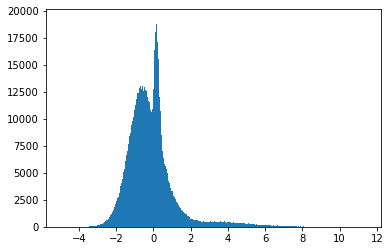

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline

len(score_list)

plt.hist(score_list, bins=500)

## use asnorm TH to set testing TH

In [199]:
TH = 1.9

In [200]:
final_spk_out = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_scores_as2.txt'
final_spk_out_tune = '/workspace/DATASET/server9_ssd/PVTC20/task1/spk_tune_out_as.txt'

In [201]:
with open(final_spk_out, 'r') as f:
    ori_out = f.readlines()

In [202]:
ori_out[0]

'PVTC_task1_0001.wav PVTC_task1_0002.wav PVTC_task1_0003.wav PVTC_task1_0004.wav 3.6198\n'

In [203]:
with open(final_spk_out_tune, 'w') as f:
    for line in ori_out:
        line = line[:-1]
        score = float(line.split(' ')[-1])
        if score > TH:
            score = 1
        else:
            score = 0
        data = line.split(' ')
        f.write(data[0]+' '+data[1]+' '+data[2]+' '+data[3]+' '+str(score)+'\n')